# Loading in Concave Pit Data

## Data Types

Height data in this project comes in two formats, each with pros and cons. This will ingest both types and output a single format type for both.

### Type 1. Keyence ASCII Raster

This dataset includes several lines of metadata and comma separated lists of height data, representing a raster dataset

**Pros:** 
* Clear Metadata
* Grid positions (row, col) of datapoints are obvious

**Cons:**
* X-Y positions need to be computed

### Type 2. Coordinate Triplet List

This dataset includes lines of 3 values, which are x, y, and z coordinates

**Pros:** 
* X, Y positions are given

**Cons:**
* No in-file Metadata
* Grid positions (row, col) are not obvious


## 2. Load Keyence Data, view it, and export it

### First we open the file and extract key metadata

In [115]:
keyfile = 'Key_example.csv'

with open(keyfile) as kf:
    line = kf.readline()
    count = 1
    while line:
        metadata_field = line.split(',')[0]
        if metadata_field == 'XY calibration':
            xy_res      = float(line.split(',')[1])
            xy_res_unit = line.split(',')[2]
            print('xy resolution: %0.3f %s' % (xy_res, xy_res_unit))
        elif metadata_field == 'Z calibration':
            z_res      = float(line.split(',')[1])
            z_res_unit = line.split(',')[2]
            print('z resolution: %0.3f %s' % (z_res, z_res_unit))
        elif metadata_field == 'Width':
            array_size_line = kf.readline()
            cols = int(array_size_line.split(',')[0])
            rows = int(array_size_line.split(',')[1])
            print('Raster has dimensions: %d lines by %d pixels' % (rows,cols))
            
        count += 1
        line = kf.readline()

header_lines = count - rows
print('The entire file has %d lines, %d of which are header lines' % (count,header_lines))

xy resolution: 694.430 nm/pixel
z resolution: 0.100 nm/digit
Raster has dimensions: 768 lines by 1024 pixels
The entire file has 820 lines, 52 of which are header lines


### Now that we know the size and scale of the data, we can view and evaluate the data

In [116]:
# Import the actual data
import numpy as np

z_data = np.loadtxt(keyfile,skiprows=header_lines,delimiter=',')
print('The shape of the height data is: ',z_data.shape)


The shape of the height data is:  (768, 1024)


If we assume the resolution units are based in nm (see above), then we can use the resolution values to convert from integer values to SI units.

In [117]:
#Assumes z_res value is in nm/digit

#Convert things from nm to um
z_res *= 0.001
#z resolution is now in um

ZZ = z_res * z_data
#ZZ is z_data but now in nm

print('The height range is %0.6f - %0.6f microns' % (np.min(ZZ),np.max(ZZ)))

#Get the grid cell coordinates as well

xy_res *= 0.001
#resoultion now in um

Xs = np.arange(cols) * xy_res
Ys = np.arange(rows) * xy_res
XX,YY = np.meshgrid(Xs,Ys) #This makes a grid of all X,Y coordinate points

The height range is 0.000000 - 349.019700 microns


**We can visualize this raster image using the imshow method**

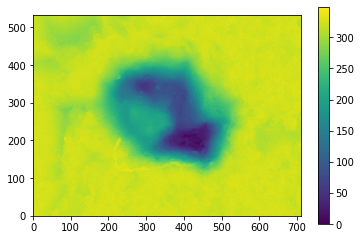

In [118]:
import matplotlib.pyplot as plt

map_extent = [np.min(Xs),np.max(Xs),np.min(Ys),np.max(Ys)]
plt.imshow(ZZ,extent=map_extent)
plt.colorbar()
plt.show()

*N.B. 300 um is 0.3 mm*

### Exporting the Data as a CSV with some lines of metadata

This data will be exported to a csv file of coordinate triplets that includes commented header lines to preserve some information

In [119]:
export_filename = 'key_list_coors.csv'

#Flatten the array data for export (we want a list, not another grid!)
XXexport = XX.flatten()
YYexport = YY.flatten()
ZZexport = ZZ.flatten()

with open(export_filename, 'w') as ef:
    ef.write('# Produced from Keyence Raster: %s\n' % keyfile)
    ef.write('# Units: um\n')
    ef.write('# x,y resolution: %0.6f\n' % xy_res)
    ef.write('# vertical resolution: %0.6f\n' % z_res)
    ef.write('# \n# x, y, z\n')
    
    #Now export the data!
    for i in range(len(ZZexport)):
        ef.write('%0.8f,%0.8f,%0.8f\n' % (XXexport[i],YYexport[i],ZZexport[i]))
        
#Here's an example of what the data look like:
for i in range(10):
    print('%0.8f,%0.8f,%0.8f' % (XXexport[i],YYexport[i],ZZexport[i]))
    
    

0.00000000,0.00000000,322.28650000
0.69443000,0.00000000,320.81990000
1.38886000,0.00000000,321.18820000
2.08329000,0.00000000,322.74650000
2.77772000,0.00000000,322.84480000
3.47215000,0.00000000,317.88300000
4.16658000,0.00000000,316.07130000
4.86101000,0.00000000,318.03970000
5.55544000,0.00000000,319.27300000
6.24987000,0.00000000,314.44130000


## 3. Load CSV List Data, view it, and export it

The second data type is a list of measurements with x,y,z coordinate triplets. We can load this in and deduce the grid spacing from the x and y values.

In [120]:
csvfile = 'CSV_example.csv'

csv_data = np.loadtxt(csvfile,delimiter=',')

#print the first 10 records
print('The first 10 records look like:')
print(csv_data[0:10])

x_data = csv_data[:,0]
y_data = csv_data[:,1]
z_data = csv_data[:,2]

print('')
print('In total, there are %d coordinates' % len(csv_data))
print('The x and y data ranges are: (%0.6f, %0.6f), (%0.6f, %0.6f)' % (np.min(x_data),np.max(x_data),np.min(y_data),np.max(y_data)))
print('The z data range is: (%0.6f, %0.6f)' % (np.min(z_data),np.max(z_data)))
print('90%% of the heights are between %0.6f and %0.6f' % (np.percentile(z_data,5),np.percentile(z_data,95)))

The first 10 records look like:
[[6.541482 6.601854 6.76991 ]
 [6.55151  6.611882 6.76991 ]
 [6.561567 6.62191  6.76991 ]
 [6.571595 6.631938 6.76991 ]
 [6.581623 6.25997  6.76991 ]
 [6.591651 6.25997  6.76991 ]
 [6.601679 6.25997  6.76991 ]
 [6.611736 6.25997  6.76991 ]
 [6.621764 6.25997  7.062024]
 [6.631792 6.25997  7.049537]]

In total, there are 4248 coordinates
The x and y data ranges are: (6.330778, 6.842671), (6.259970, 6.769910)
The z data range is: (2.936000, 7.109788)
90% of the heights are between 6.872926 and 7.104584


#### Here we realize that the pit data is not what we initially figured...

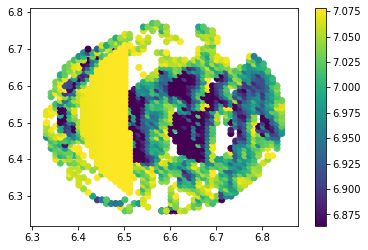

In [121]:
csv_data = csv_data[np.where(csv_data[:,2]<7.08)]

lx_data = csv_data[:,0]
ly_data = csv_data[:,1]
lz_data = csv_data[:,2]

plt.clf()
msize = csv_data[:,2]*-1 + 8
plt.scatter(lx_data,ly_data,c=lz_data)
plt.clim([np.percentile(lz_data,10),np.percentile(lz_data,90)])
plt.colorbar()
plt.show()

**And we'